## Doublet Removal - Scrublet: sc_85_1g

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import scrublet as scr
import scipy
import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# data files are in the filtered matrix folder from CellRanger which has been renamed to the sample name
sample_name = r'sc85_1g'
data_path = r"../raw_data/"
data_files_path = data_path + sample_name + r""

results_path = 'results/'
results_file = results_path + sample_name + 'scrublet_sc85_1g-db.h5ad'  # the file that will store the analysis results
metrics_file = results_path + sample_name + 'scrublet_sc85_1g_db_metrics.csv'  # the file that will store the metrics
# make results folder if it doesn't exist
if not os.path.exists(results_path):
    os.makedirs(results_path, exist_ok=False)

C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import

scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


#### Load data

Read in count data into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object.  
The matrix.mtx file contains a sparse matrix of the counts.  
Barcodes file contains the sample names in the format: AAACCCAAGACCATAA-1  
Features file contains the gene id in the format: ENSMUSG00000051951, Xkr4, Gene Expression

The number of counts per cell will be relatively low since only UMIs are counted by Cellranger

In [2]:
adata = sc.read_10x_mtx(
    data_files_path,              # the directory with the `.mtx` file
    var_names='gene_symbols',     # use gene symbols for the variable names (variables-axis index)
    cache=True)                   # write a cache file for faster subsequent reading

# adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()

# make the obs names unique by adding the sample name
adata.obs_names = [g.split("-")[0] + '_' + sample_name for g in adata.obs_names]
print(adata.obs_names[0:2])
print()
print('Number of cells =', f"{adata.n_obs:,.0f}")
print('Number of genes =', f"{adata.n_vars:,.0f}")
print('Number of counts =', f"{adata.X.sum():,.0f}")
print('Mean counts per cell =', f"{adata.X.sum()/adata.n_obs:,.0f}")
adata

... reading from cache file cache\..-raw_data-sc85_1g-matrix.h5ad
Data matrix is sparse: True

Index(['AAACAGCCAACCGCCA_sc85_1g', 'AAACAGCCAAGGTATA_sc85_1g'], dtype='object')

Number of cells = 15,830
Number of genes = 36,530
Number of counts = 13,291,714
Mean counts per cell = 840


AnnData object with n_obs × n_vars = 15830 × 36530
    var: 'gene_ids', 'feature_types'

In [3]:
n_cells = adata.n_obs
n_genes = adata.n_vars
n_counts = adata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame([n_cells, n_genes, n_counts, counts_per_cell], \
                  index = ['Number of cells', 'Number of genes', 'Number of counts','Mean counts per cell']).T
df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

C:\Users\leeh1\AppData\Local\Temp\ipykernel_21408\1815972615.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_21408\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    36,530
Name: Number of genes, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_21408\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    13,291,714
Name: Number of counts, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc85_1g,15830.0,"36,530","13,291,714",840


### Detect doublets
Remove "empty" genes before doublet detection.

In [4]:
sc.pp.filter_genes(adata, min_cells=1)
df_metrics['Filter genes:'] = ' '
df_metrics['Number of genes removed'] = n_genes - adata.n_vars

filtered out 11479 genes that are detected in less than 1 cells


#### Initialize scrublet object

Provided by Tiffany:
`expected_doublet_rate`=0.06
	•	This parameter tells Scrublet the expected proportion of doublets in the dataset. In this case, 6% of the cells are expected to be doublets.
	•	The default value is usually dataset-specific, as the doublet rate depends on factors like the sequencing platform, the number of cells captured, and the total volume of the library.
	•	For droplet-based methods (e.g., 10x Genomics), 5-10% is common.
	•	For plate-based methods, the rate may be lower.

Instead I will try to use the 10x formula Prof. McKinnon uses:

In [5]:
data_mat = adata.X                # transform data matrix
print(data_mat.shape)  
doublet_ratio = n_cells/1000*0.008   # calculate multiplet rate based on 10x formula
print('multiplet rate = %4.1f' %(doublet_ratio*100), '%')

(15830, 25051)
multiplet rate = 12.7 %


In [6]:
# Initialize Scrublet object 
scrub = scr.Scrublet(data_mat, expected_doublet_rate=doublet_ratio)

#### Run the default pipeline, which includes:
1. Doublet simulation
2. Normalization, gene filtering, rescaling, PCA
3. Doublet score calculation 
4. Doublet score threshold detection and doublet calling


In [7]:
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.68
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 12.7%
	Estimated  = 12.5%
Elapsed time: 16.3 seconds


In [8]:
doublet_count = np.sum(predicted_doublets)
print(f"Number of predicted doublets: {doublet_count}")

Number of predicted doublets: 1


In [10]:
adata.obs['doublet_score'] = doublet_scores
adata.obs['is_doublet'] = ['Doublet' if x == 1 else 'Singlet' for x in predicted_doublets]

In [11]:
doublet_percentage = doublet_count/adata.n_obs*100
print('Doublet percentage = %4.1f' %(doublet_percentage))

Doublet percentage =  0.0


In [12]:
num_before = adata.n_obs
singlets = adata.obs["is_doublet"] == 'Singlet'
num_after = adata[singlets].n_obs
n_genes = adata[singlets].n_vars
n_counts = adata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before doublet removal =', num_before)
print('Number of cells after doublet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = adata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After doublet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before doublet removal = 15830
Number of cells after doublet removal = 15829
Number of cells removed = 1
Percentage of cells removed =  0.0
Number of counts = 13,291,714
Mean counts per cell = 840


In [13]:
adata[singlets].write(results_file)

C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\_core\anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\anndata\_core\anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [14]:
df_metrics.T.to_csv(metrics_file)

### Visualize in UMAP

In [15]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:59)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


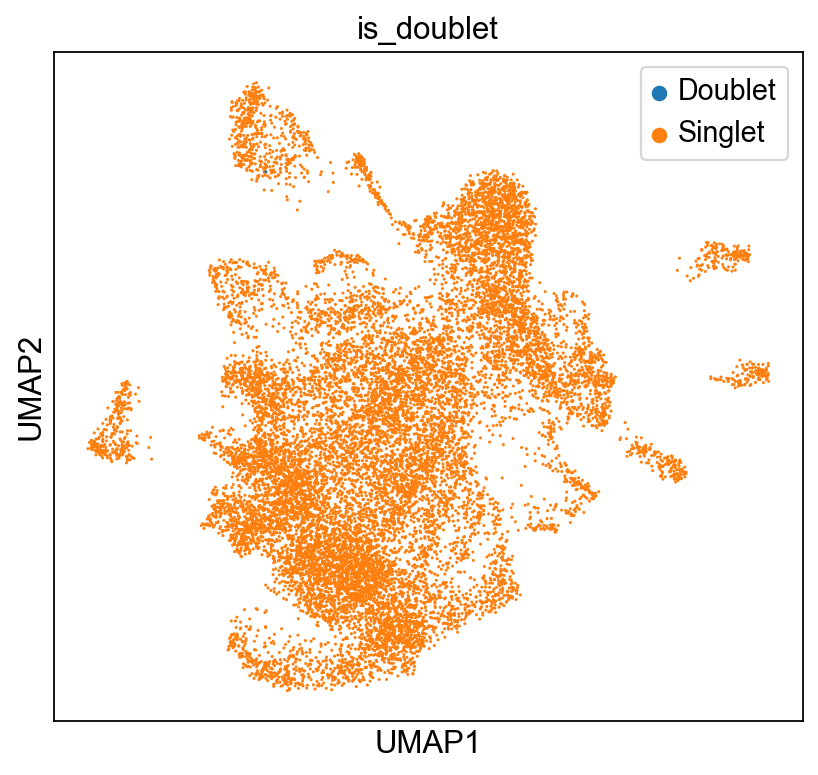

In [16]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(adata, color='is_doublet', legend_loc='best')

### Exporting Doublets to a `.txt` file
Printing out doublet subsets for future comparisons

In [43]:
adata_dbl = adata.obs['is_doublet'] == 'Doublet'
adata_dbl = adata.obs_names[adata_dbl]

In [45]:
print(adata_dbl)

Index(['GACCTGCAGTCATCCC_sc85_1g'], dtype='object')


In [49]:
with open("./results/Scrublet_sc85_1g_ids.txt", "w") as txt_file:
    for cell in adata_dbl:
        txt_file.write(cell + "\n")